In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
DATA_PATH = 'full_data_batch_label/labeled/comments_with_sentiment.csv'

In [3]:
comments_sentiment_df = pd.read_csv(DATA_PATH)

# Remove entries with 'error' label
comments_sentiment_df = comments_sentiment_df[~(comments_sentiment_df.predicted_label == 'error')]

# Convert to datetime
comments_sentiment_df.created = pd.to_datetime(comments_sentiment_df.created)

# Subdivide created timestamp to year (2018-2023) and week (1-53) format
comments_sentiment_df['week_created'] = comments_sentiment_df.created.dt.strftime('%Y-%U')

# Prepare flags for specific timeframes (e.g. vacation, exams)
comments_sentiment_df['flag'] = 'regular'


# Remove comments with empty body text
comments_sentiment_df.dropna(subset='body', inplace=True)

# Further subdivide into school years
df_2018f = comments_sentiment_df[(comments_sentiment_df['created'] > '2018-09-04') & (comments_sentiment_df['created'] < '2019-01-08')].copy()
df_2019w = comments_sentiment_df[(comments_sentiment_df['created'] > '2019-01-09') & (comments_sentiment_df['created'] < '2019-09-02')].copy()
df_2019f = comments_sentiment_df[(comments_sentiment_df['created'] > '2019-09-03') & (comments_sentiment_df['created'] < '2020-01-07')].copy()
df_2020w = comments_sentiment_df[(comments_sentiment_df['created'] > '2020-01-08') & (comments_sentiment_df['created'] < '2020-08-29')].copy()
df_2020f = comments_sentiment_df[(comments_sentiment_df['created'] > '2020-08-30') & (comments_sentiment_df['created'] < '2021-01-18')].copy()
df_2021w = comments_sentiment_df[(comments_sentiment_df['created'] > '2021-01-19') & (comments_sentiment_df['created'] < '2021-09-01')].copy()
df_2021f = comments_sentiment_df[(comments_sentiment_df['created'] > '2021-09-02') & (comments_sentiment_df['created'] < '2022-01-04')].copy()
df_2022w = comments_sentiment_df[(comments_sentiment_df['created'] > '2022-01-05') & (comments_sentiment_df['created'] < '2022-08-28')].copy()

In [4]:
comments_sentiment_df.head()

,idstr,created,parent,submission,body,score,predicted_label,confidence,week_created,flag
0,t1_fkvzrtb,2020-03-19 01:10:44,t3_fkzxge,t3_fkzxge,This is a great idea!!! Thanks for starting this.,14.0,positive,0.989029,2020-11,regular
1,t1_fkvzyub,2020-03-19 01:12:43,t1_fkvypyl,t3_fkw1nj,"To me, the problem was that they didn't tell u...",4.0,negative,0.662670,2020-11,regular
2,t1_fkw04uf,2020-03-19 01:14:27,t1_fkvs07g,t3_fkw1nj,Plus there were people who may have left campu...,2.0,negative,0.575662,2020-11,regular
3,t1_fkw0fg1,2020-03-19 01:17:31,t1_fkvzyub,t3_fkw1nj,I think it was pretty clear that when they say...,8.0,neutral,0.581127,2020-11,regular
4,t1_fkw0gqm,2020-03-19 01:17:54,t1_fkw04uf,t3_fkw1nj,"Yeah that's ass for those people, I sympathize...",1.0,negative,0.880160,2020-11,regular


In [5]:
comments_sentiment_df.predicted_label.value_counts()/len(comments_sentiment_df)

neutral     0.514358
negative    0.260244
positive    0.225397
Name: predicted_label, dtype: float64

In [6]:
df_2022w[['body', 'predicted_label', 'score']].sample(5)

,body,predicted_label,score
141753,"As a rust user, I've found just doing course p...",positive,13.0
139666,"you shouldn't be paying them to be an intern, ...",negative,38.0
146236,Happy Cake Day u/umrobotics,positive,15.0
120099,"Nah lol you simply do not, I guarantee it. It'...",negative,2.0
150265,"In the same boat as you, 2bd Northwoods I/II -...",negative,3.0


In [7]:
# Special flag 'bos': Beginning of the Semester
# 2021f
df_2021f.loc[(df_2021f['week_created'] == '2021-34') | (df_2021f['week_created'] == '2021-35'), 'flag'] = 'bos'
# 2022w
df_2022w.loc[(df_2022w['week_created'] == '2022-00') | (df_2022w['week_created'] == '2022-01'), 'flag'] = 'bos'

# Special flag 'vac': Vacation
# 2021f (thanksgiving, winter break)
df_2021f.loc[(df_2021f['week_created'] == '2021-46'), 'flag'] = 'vac'
df_2021f.loc[(df_2021f['week_created'] == '2021-51') | (df_2021f['week_created'] == '2021-52'), 'flag'] = 'vac'
# 2022w (spring break, summer break)
df_2022w.loc[(df_2022w['week_created'] == '2022-09'), 'flag'] = 'vac'
df_2022w.loc[(df_2022w['week_created'] >= '2022-17') & (df_2022w['week_created'] <= '2022-33'), 'flag'] = 'vac'

# Special flag '2w': Two Weeks Before or After Spring/Thanksgiving Break
# 2021f
df_2021f.loc[(df_2021f['week_created'] == '2021-44') | (df_2021f['week_created'] == '2021-45'), 'flag'] = '2w'
df_2021f.loc[(df_2021f['week_created'] == '2021-47') | (df_2021f['week_created'] == '2021-48'), 'flag'] = '2w'
# 2022w
df_2022w.loc[(df_2022w['week_created'] == '2022-07') | (df_2022w['week_created'] == '2022-08'), 'flag'] = '2w'
df_2022w.loc[(df_2022w['week_created'] == '2022-10') | (df_2022w['week_created'] == '2022-11'), 'flag'] = '2w'

# Special flag 'fnl': Two Weeks Before Winter/Summer Break
df_2021f.loc[(df_2021f['week_created'] == '2021-49') | (df_2021f['week_created'] == '2021-50'), 'flag'] = 'fnl'
df_2022w.loc[(df_2022w['week_created'] == '2022-15') | (df_2022w['week_created'] == '2022-16'), 'flag'] = 'fnl'

In [8]:
df_2022w.flag.value_counts()

vac        17025
regular    13192
2w          4980
fnl         3426
bos         1271
Name: flag, dtype: int64

In [9]:
df_2021f.flag.value_counts()

regular    9208
2w         3985
vac        2924
fnl        2449
bos         748
Name: flag, dtype: int64

#### Plot 1
Content with negative sentiment tends to have more polarized scores.

In [174]:
target_df = pd.concat([df_2021f, df_2022w], axis=0)
#target_df = df_2021f

In [245]:
plot1_subdf = comments_sentiment_df[['score', 'predicted_label']].copy()
plot1_subdf.score = np.log2(np.abs(plot1_subdf.score), where=(plot1_subdf.score != 0)) * np.sign(plot1_subdf.score)
plot1_subdf.rename(columns={'score':'log_score'}, inplace=True)

<Axes: xlabel='log_score', ylabel='Density'>

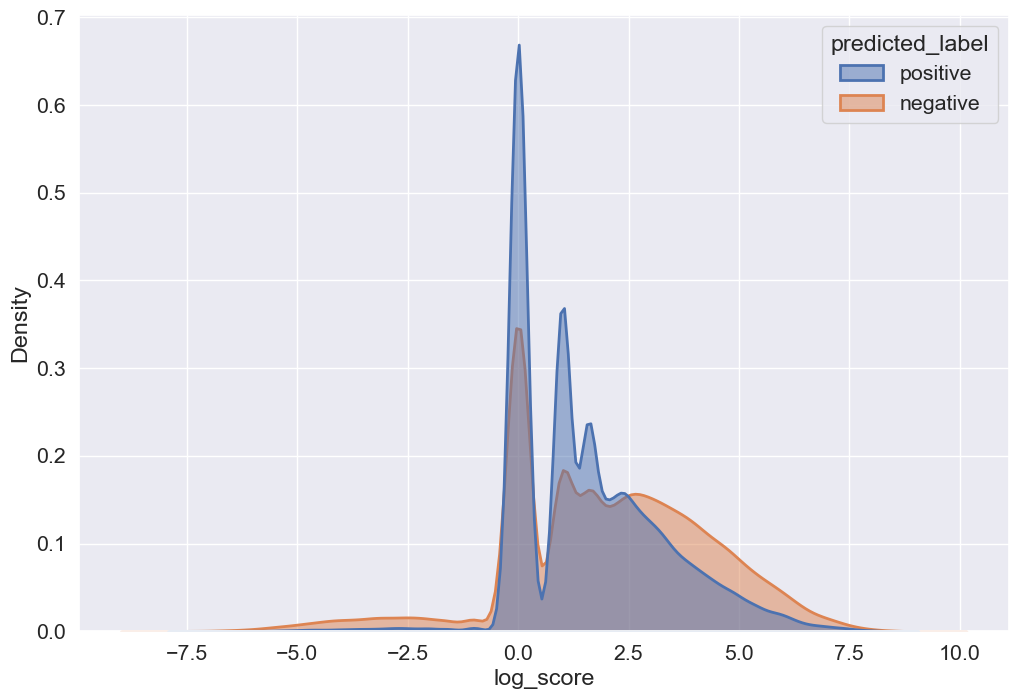

In [266]:
f, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
   data=plot1_subdf[plot1_subdf.predicted_label != 'neutral'], x="log_score", hue="predicted_label", fill=True, common_norm=False, alpha=.5, linewidth=2
)

In [160]:
# Aggregate and calculate the percentage of positive, negative, and neutral posts for each flag
aggcnt_by_flag = target_df.groupby('flag', as_index=False).predicted_label.value_counts()
aggcnt_by_flag['%'] = aggcnt_by_flag['count'] / aggcnt_by_flag.groupby('flag')['count'].transform('sum')
aggcnt_by_flag['%'] = aggcnt_by_flag['%'].round(2)
aggcnt_by_flag

,flag,predicted_label,count,%
0,2w,neutral,4401,0.49
1,2w,negative,2479,0.28
2,2w,positive,2085,0.23
3,bos,neutral,959,0.47
4,bos,negative,649,0.32
5,bos,positive,411,0.20
6,fnl,neutral,2932,0.50
7,fnl,negative,1631,0.28
8,fnl,positive,1312,0.22
9,regular,neutral,10903,0.49


#### Plot2
Sentiment distribution based on time of the school year.

/var/folders/3v/7sd65bmj2qd38hxvjnwf6p940000gn/T/ipykernel_5940/3803350421.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  percentage_pivot = aggcnt_by_flag.drop('count', axis=1).pivot('flag', 'predicted_label')


<Axes: xlabel='None-predicted_label', ylabel='flag'>

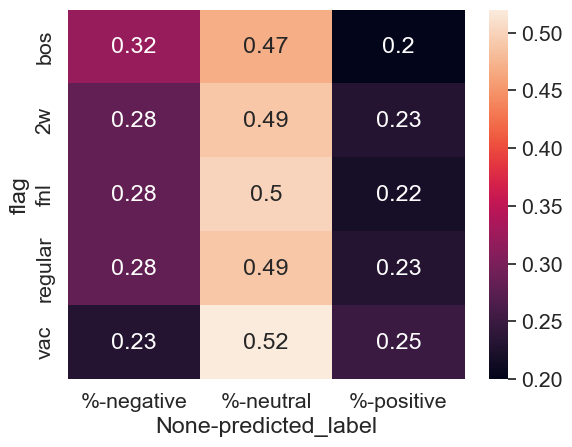

In [172]:
percentage_pivot = aggcnt_by_flag.drop('count', axis=1).pivot('flag', 'predicted_label')
percentage_pivot = percentage_pivot.reindex(percentage_pivot['%'].sort_values(by='negative', ascending=False).index)
sns.heatmap(percentage_pivot, annot=True)

In [129]:
# Aggregate and calculate the percentage of positive, negative, and neutral posts each week
aggcnt_by_week = target_df.groupby('week_created', as_index=False).predicted_label.value_counts()
aggcnt_by_week['percentage'] = aggcnt_by_week['count'] / aggcnt_by_week.groupby('week_created')['count'].transform('sum')
aggcnt_by_week['percentage'] = aggcnt_by_week['percentage'].round(2)
aggcnt_by_week.head(6)

,week_created,predicted_label,count,percentage
0,2021-35,neutral,364,0.49
1,2021-35,positive,202,0.27
2,2021-35,negative,182,0.24
3,2021-36,neutral,669,0.50
4,2021-36,negative,396,0.30
5,2021-36,positive,261,0.20


In [131]:
aggcnt_by_week

,week_created,predicted_label,count,percentage
0,2021-35,neutral,364,0.49
1,2021-35,positive,202,0.27
2,2021-35,negative,182,0.24
3,2021-36,neutral,669,0.50
4,2021-36,negative,396,0.30
5,2021-36,positive,261,0.20
6,2021-37,neutral,658,0.49
7,2021-37,negative,400,0.30
8,2021-37,positive,280,0.21
9,2021-38,neutral,647,0.52


#### Plot3
Fluctuating and inconclusive plot if we try to observe change over time without proper grouping.

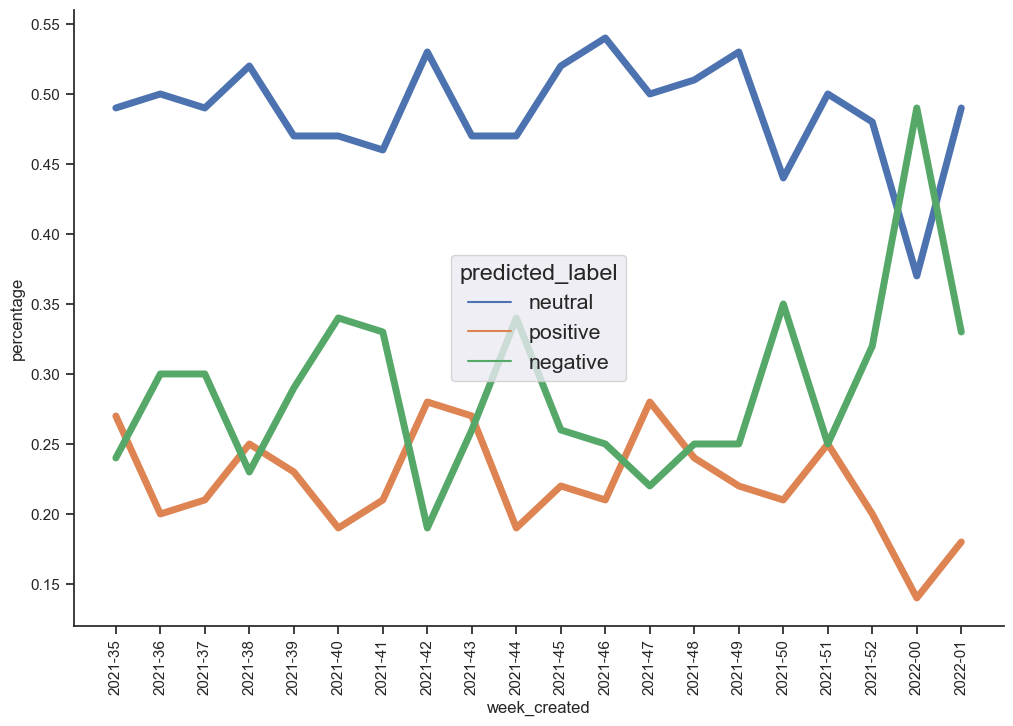

In [130]:
# Ignore 'neutral' for this analysis
#aggcnt_by_week = aggcnt_by_week[aggcnt_by_week.predicted_label != 'neutral']

f, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style="darkgrid")
sns.despine(f)
sns.set(font_scale=1.4)
sns.lineplot(
    data=aggcnt_by_week, 
    x='week_created', 
    y='percentage', 
    linewidth=5,
    hue='predicted_label')
plt.xticks(rotation=90);